In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('Sentiment.csv', usecols = ['text', 'sentiment'])[['text', 'sentiment']]
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


Dropping the 'Neutral' sentiments and keeping positive and negative tweets.

In [3]:
data = data[data['sentiment'] != 'Neutral']
data.head()

,text,sentiment
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive
5,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",Positive
6,RT @warriorwoman91: I liked her and was happy ...,Negative


In [4]:
import re

In [5]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply(lambda x: re.sub('[^a-zA-Z0-9\s]', '', x))
data['text'] = data['text'].str.replace('rt','')

data.head()

,text,sentiment
1,scottwalker didnt catch the full gopdebate la...,Positive
3,robgeorge that carly fiorina is trending hou...,Positive
4,danscavino gopdebate w realdonaldtrump delive...,Positive
5,gregabbotttx tedcruz on my first day i will r...,Positive
6,warriorwoman91 i liked her and was happy when...,Negative


Handling imbalanced classes using Up-Sampling the minority class.

In [6]:
data['sentiment'].value_counts()

Negative    8493
Positive    2236
Name: sentiment, dtype: int64

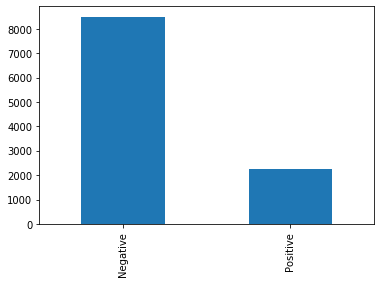

In [7]:
data['sentiment'].value_counts().plot.bar()

In [8]:
from sklearn.utils import resample

In [9]:
df_majority = data[data['sentiment'] == 'Negative']
df_minority = data[data['sentiment'] == 'Positive']

In [10]:
minority_upsampled = resample(df_minority,
                          replace=True, 
                          n_samples=len(df_majority), 
                          random_state=27) 

upsampled = pd.concat([df_majority, minority_upsampled])

upsampled.sentiment.value_counts()

Positive    8493
Negative    8493
Name: sentiment, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, SpatialDropout1D, GlobalMaxPooling1D, Conv1D, MaxPooling1D

In [12]:
X = upsampled['text']
y = upsampled['sentiment'].map({'Negative': 0, 'Positive': 1}).values

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

In [14]:
# Convert sentences to sequences
top_words = 10000
tokenizer = Tokenizer(num_words=top_words, split=' ')
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [15]:
# get word to integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 12829 unique tokens.


In [16]:
maxlen = max([len(x) for x in X_train])
maxlen

141

In [17]:
# pad sequences to get a N x T matrix
data_train = pad_sequences(sequences_train, maxlen=maxlen)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor: (11380, 141)


In [18]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (5606, 141)


In [19]:
# Create the model
# Embedding dimensionality (embedding vecor length)
D = 20
# Hidden state dimensionality (LSTM units)
M = 128
# Embedding size (V + 1) x D # +1 for the 0 padding
# because the first index starts from 1 and not 0.
model = Sequential()
model.add(Embedding(V+1, D, input_length=T))
model.add(SpatialDropout1D(0.2))
# model.add(LSTM(M, return_sequences=True))
model.add(LSTM(M, dropout=0.2, recurrent_dropout=0.2))
# model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 141, 20)           256600    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 141, 20)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               76288     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 333,017
Trainable params: 333,017
Non-trainable params: 0
_________________________________________________________________


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [22]:
print('Training model...')
r = model.fit(
    data_train,
    y_train,
    epochs=30,
    batch_size=128,
    validation_data=(data_test, y_test),
    callbacks=[early_stop]
)

Training model...
Epoch 1/30
89/89 [==============================] - 54s 608ms/step - loss: 0.5742 - accuracy: 0.6856 - val_loss: 0.4617 - val_accuracy: 0.7836
Epoch 2/30
89/89 [==============================] - 67s 753ms/step - loss: 0.3210 - accuracy: 0.8677 - val_loss: 0.3157 - val_accuracy: 0.8646
Epoch 3/30
89/89 [==============================] - 65s 735ms/step - loss: 0.2224 - accuracy: 0.9125 - val_loss: 0.2809 - val_accuracy: 0.8874
Epoch 4/30
89/89 [==============================] - 75s 846ms/step - loss: 0.2539 - accuracy: 0.9025 - val_loss: 0.2880 - val_accuracy: 0.8866
Epoch 5/30
89/89 [==============================] - 63s 710ms/step - loss: 0.1782 - accuracy: 0.9359 - val_loss: 0.2525 - val_accuracy: 0.9001
Epoch 6/30
89/89 [==============================] - 66s 746ms/step - loss: 0.1365 - accuracy: 0.9504 - val_loss: 0.2553 - val_accuracy: 0.9078
Epoch 7/30
89/89 [==============================] - 69s 771ms/step - loss: 0.1166 - accuracy: 0.9568 - val_loss: 0.2449 - va

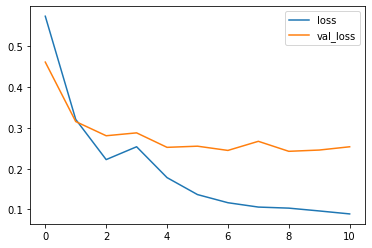

In [23]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

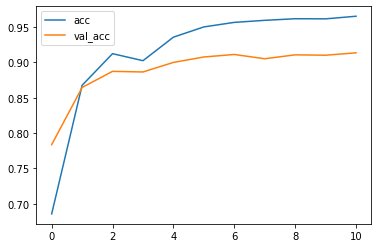

In [24]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [25]:
scores = model.evaluate(data_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 91.37%


In [26]:
y_pred = model.predict(data_test, batch_size = 128).flatten().round()
# y_pred

In [27]:
# y_pred = y_pred.flatten().round()
# y_pred

In [28]:
from sklearn.metrics import confusion_matrix,classification_report

In [29]:
print("confusion matrix \n",confusion_matrix(y_test, y_pred))
print("\nclassification_report \n", classification_report(y_test, y_pred))

confusion matrix 
 [[2535  268]
 [ 216 2587]]

classification_report 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      2803
           1       0.91      0.92      0.91      2803

    accuracy                           0.91      5606
   macro avg       0.91      0.91      0.91      5606
weighted avg       0.91      0.91      0.91      5606



In [30]:
tweet = ["I don’t find the app useful: it’s really slow and constantly crashing."]
tweet = tokenizer.texts_to_sequences(tweet)
tweet = pad_sequences(tweet, maxlen=maxlen, padding='post', truncating='post')

sentiment = model.predict(tweet,batch_size = 1)[0]
sentiment = sentiment.flatten().round()
if(sentiment == 0):
    print("negative")
elif (sentiment == 1):
    print("positive")

negative


In [31]:
# Create the model using CNN
# We get to choose embedding dimensionality
D = 20

model = Sequential()
model.add(Embedding(V + 1, D, input_length = T))
model.add(Conv1D(filters=32, kernel_size=(3), activation='relu', input_shape = (T,)))
model.add(MaxPooling1D(3))
model.add(Conv1D(filters=64, kernel_size=(3), activation='relu'))
# model.add(MaxPooling1D(3))
# model.add(Conv1D(filters=128, kernel_size=(3), activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1,activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 141, 20)           256600    
_________________________________________________________________
conv1d (Conv1D)              (None, 139, 32)           1952      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 46, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 64)            6208      
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 264,825
Trainable params: 264,825
Non-trainable params: 0
________________________________________________

In [32]:
print('Training model...')
r = model.fit(
    data_train,
    y_train,
    epochs=30,
    batch_size = 128,
    validation_data=(data_test, y_test),
    callbacks=[early_stop]
)

Training model...
Epoch 1/30
89/89 [==============================] - 4s 41ms/step - loss: 0.6285 - accuracy: 0.6749 - val_loss: 0.4621 - val_accuracy: 0.7961
Epoch 2/30
89/89 [==============================] - 3s 38ms/step - loss: 0.3105 - accuracy: 0.8766 - val_loss: 0.3035 - val_accuracy: 0.8689
Epoch 3/30
89/89 [==============================] - 3s 38ms/step - loss: 0.1743 - accuracy: 0.9359 - val_loss: 0.2619 - val_accuracy: 0.9044
Epoch 4/30
89/89 [==============================] - 3s 38ms/step - loss: 0.1252 - accuracy: 0.9544 - val_loss: 0.2589 - val_accuracy: 0.9037
Epoch 5/30
89/89 [==============================] - 3s 39ms/step - loss: 0.0995 - accuracy: 0.9627 - val_loss: 0.2595 - val_accuracy: 0.9096
Epoch 6/30
89/89 [==============================] - 3s 39ms/step - loss: 0.0878 - accuracy: 0.9678 - val_loss: 0.2577 - val_accuracy: 0.9140
Epoch 7/30
89/89 [==============================] - 3s 39ms/step - loss: 0.0810 - accuracy: 0.9693 - val_loss: 0.2611 - val_accuracy: 0.

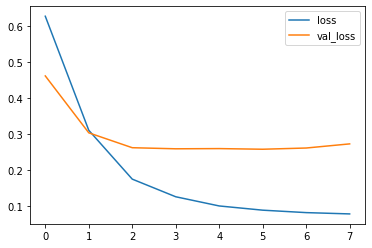

In [33]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

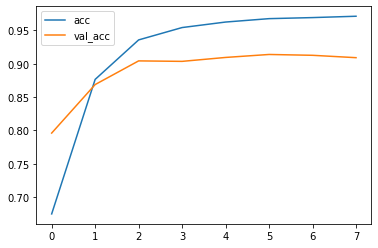

In [34]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [35]:
scores = model.evaluate(data_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 90.92%


In [36]:
y_pred = model.predict(data_test, batch_size = 128).flatten().round()
# y_pred

In [37]:
# y_pred = y_pred.flatten().round()
# y_pred

In [38]:
from sklearn.metrics import confusion_matrix,classification_report

In [39]:
print("confusion matrix \n",confusion_matrix(y_test, y_pred))
print("\nclassification_report \n", classification_report(y_test, y_pred))

confusion matrix 
 [[2392  411]
 [  98 2705]]

classification_report 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      2803
           1       0.87      0.97      0.91      2803

    accuracy                           0.91      5606
   macro avg       0.91      0.91      0.91      5606
weighted avg       0.91      0.91      0.91      5606



In [40]:
tweet = ["I don’t find the app useful: it’s really slow and constantly crashing."]
tweet = tokenizer.texts_to_sequences(tweet)
tweet = pad_sequences(tweet, maxlen=maxlen, padding='post', truncating='post')

sentiment = model.predict(tweet,batch_size = 1)[0]
sentiment = sentiment.flatten().round()
if(sentiment == 0):
    print("negative")
elif (sentiment == 1):
    print("positive")

negative
